<a href="https://colab.research.google.com/github/Anik-1802021/ML-Autoencoder-denoise-custom-dataset/blob/main/Denoise_Autoencoder_custom_dataset_v_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

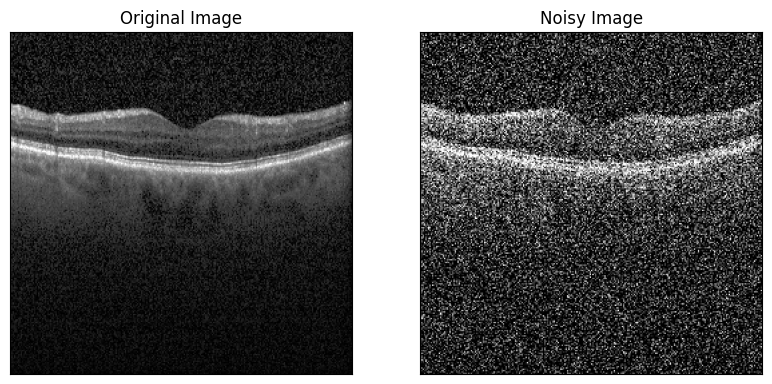

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 batch_normalization_12 (Ba  (None, 256, 256, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_13 (Ba  (None, 128, 128, 64)     

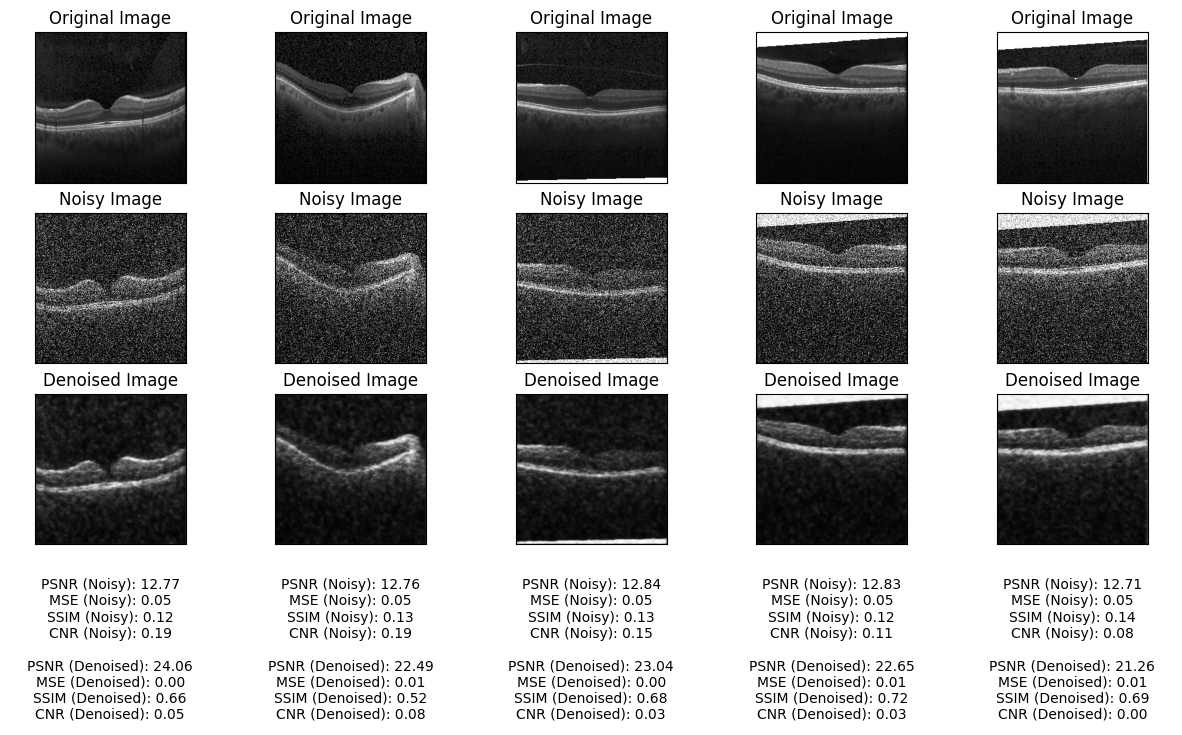

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import legacy
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2
from skimage.metrics import structural_similarity as ssim

# Function to calculate PSNR
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0  # As the pixel values are normalized to [0, 1]
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

# Function to calculate MSE
def mse(img1, img2):
    return np.mean((img1 - img2) ** 2)

# Function to calculate SSIM
def calculate_ssim(img1, img2):
    img1 = img1.squeeze()  # Remove channel dimension for SSIM calculation
    img2 = img2.squeeze()
    ssim_value, _ = ssim(img1, img2, full=True)
    return ssim_value

# Function to calculate CNR (simple implementation)
def calculate_cnr(img1, img2):
    mean1, std1 = cv2.meanStdDev(img1)
    mean2, std2 = cv2.meanStdDev(img2)
    cnr_value = abs(mean1 - mean2) / (std1 + std2)
    return cnr_value[0][0]

# Function to load and preprocess images
def load_images_from_folder(folder, image_size=(512, 512)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = load_img(img_path, color_mode='grayscale', target_size=image_size)
            img = img_to_array(img)
            images.append(img)
    images = np.array(images)
    images = images.astype('float32') / 255.  # Normalizing the images
    return images

# Specify the path to the dataset folder
dataset_folder = '/content/drive/MyDrive/Thesis/custom_dataset/train/NORMAL'  # Replace with your folder path

# Load images from the specified dataset folder
image_size = (256, 256)
images = load_images_from_folder(dataset_folder, image_size)

# Reshape images to add the channel dimension
images = np.reshape(images, (images.shape[0], image_size[0], image_size[1], 1))

# Split the data into training and test sets
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

# Add noise to the data
noise_factor = 0.3  # Adjusted noise factor
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Displaying original, noisy, and denoised images
n = 1
plt.figure(figsize=(15, 5))
for i in range(n):
    # Display original image
    ax = plt.subplot(1, 3, 1)
    plt.imshow(x_train[i].reshape(image_size), cmap='gray')
    ax.set_title('Original Image')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy image
    ax = plt.subplot(1, 3, 2)
    plt.imshow(x_train_noisy[i].reshape(image_size), cmap='gray')
    ax.set_title('Noisy Image')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Building the denoising autoencoder model
input_shape = (image_size[0], image_size[1], 1)
denoise = Sequential()
denoise.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))  # Increased filters
denoise.add(BatchNormalization())
denoise.add(Activation('relu'))
denoise.add(MaxPooling2D((2, 2), padding='same'))
denoise.add(Conv2D(64, (3, 3), padding='same'))  # Increased filters
denoise.add(BatchNormalization())
denoise.add(Activation('relu'))
denoise.add(UpSampling2D((2, 2)))
denoise.add(Conv2D(32, (3, 3), padding='same'))
denoise.add(BatchNormalization())
denoise.add(Activation('relu'))
denoise.add(Conv2D(1, (3, 3), padding='same'))
denoise.add(BatchNormalization())
denoise.add(Activation('sigmoid'))

# Compiling the model
learning_rate = 0.01  # Adjusted learning rate
decay_rate = 1e-6  # Adjusted decay rate
momentum = 0.9
sgd = legacy.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
denoise.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
denoise.summary()

# Training the model
denoise.fit(x_train_noisy, x_train, epochs=20, batch_size=16, validation_data=(x_test_noisy, x_test), verbose=1)  # Adjusted epochs and batch size

# Predicting on the noisy images
denoised_images = denoise.predict(x_test_noisy)

# Displaying original images, noisy images, and denoised images
n = 5
plt.figure(figsize=(15, 9))
for i in range(n):
    # Display original image
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_test[i].reshape(image_size), cmap='gray')
    ax.set_title('Original Image')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy image
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(image_size), cmap='gray')
    ax.set_title('Noisy Image')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised image
    ax = plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(image_size), cmap='gray')
    ax.set_title('Denoised Image')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display metrics
    psnr_noisy = psnr(x_test[i], x_test_noisy[i])
    mse_noisy = mse(x_test[i], x_test_noisy[i])
    ssim_noisy = calculate_ssim(x_test[i], x_test_noisy[i])
    cnr_noisy = calculate_cnr(x_test[i], x_test_noisy[i])

    psnr_denoised = psnr(x_test[i], denoised_images[i])
    mse_denoised = mse(x_test[i], denoised_images[i])
    ssim_denoised = calculate_ssim(x_test[i], denoised_images[i])
    cnr_denoised = calculate_cnr(x_test[i], denoised_images[i])

    ax = plt.subplot(4, n, i + 1 + 3*n)
    metrics_text = f"PSNR (Noisy): {psnr_noisy:.2f}\nMSE (Noisy): {mse_noisy:.2f}\nSSIM (Noisy): {ssim_noisy:.2f}\nCNR (Noisy): {cnr_noisy:.2f}\n\nPSNR (Denoised): {psnr_denoised:.2f}\nMSE (Denoised): {mse_denoised:.2f}\nSSIM (Denoised): {ssim_denoised:.2f}\nCNR (Denoised): {cnr_denoised:.2f}"
    plt.text(0.5, 0.5, metrics_text, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.axis('off')
plt.show()
